<a href="https://colab.research.google.com/drive/1dCvmYxlZCAF-a0f-i87fybdlghXcy-4w?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# <center>SHAP Interpretation </center>

> # Introduction

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

> # Competition link

*   https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview

> # Data description

*   https://raw.githubusercontent.com/DavidGomezCamargo/Project/main/data_description.txt

> # SHAP

SHAP stands for “SHapley Additive exPlanations.” Shapley values are a widely used approach from cooperative game theory. The essence of Shapley value is to measure the contributions to the final outcome from each player separately among the coalition, while preserving the sum of contributions being equal to the final outcome.

When using SHAP values in model explanation, we can measure the input features’ contribution to individual predictions. We won’t be covering the complex formulas to calculate SHAP values in this article, but we’ll show how to use the SHAP Python library to easily calculate SHAP values.

There are some other techniques used to explain models like permutation importance and partial dependence plots. Here are some benefits of using SHAP values over other techniques:

1.   Global interpretability: SHAP values not only show feature importance but also show whether the feature has a positive or negative impact on predictions.
2.   Local interpretability: We can calculate SHAP values for each individual prediction and know how the features contribute to that single prediction. Other techniques only show aggregated results over the whole dataset.
3.   SHAP values can be used to explain a large variety of models including linear models (e.g. linear regression), tree-based models (e.g. XGBoost) and neural networks, while other techniques can only be used to explain limited model types.

> # Other resources

*   https://www.youtube.com/watch?v=-taOhqkiuIo
*   https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf
*   https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
*   https://proceedings.neurips.cc/paper/2017/hash/8a20a8621978632d76c43dfd28b67767-Abstract.html

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
!pip install shap
import shap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.1/547.1 kB 7.2 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Loading the dataset

train_dataset = pd.read_csv('https://raw.githubusercontent.com/DavidGomezCamargo/Project/main/train.csv')
test_dataset = pd.read_csv('https://raw.githubusercontent.com/DavidGomezCamargo/Project/main/test.csv')
train_dataset.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Selecting features

train_dataset = train_dataset.drop('Id', axis=1)
X_train = pd.get_dummies(train_dataset.drop('SalePrice', axis=1))
y_train = train_dataset['SalePrice']
X_train.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [4]:
X_test = pd.get_dummies(test_dataset.drop('Id', axis=1))
X_test.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [5]:
# Preprocessing null values

imputer = SimpleImputer()
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns = X_train.columns)

In [6]:
# GradientBoostingRegressor as our estimator

estimator = GradientBoostingRegressor(random_state = 0)
estimator.fit(X_train_imputed, y_train)
scores = cross_val_score(estimator, X_train_imputed, y_train, cv=5, scoring= 'r2')
print("Average CV score:", scores.mean())

Average CV score: 0.8864146278198847


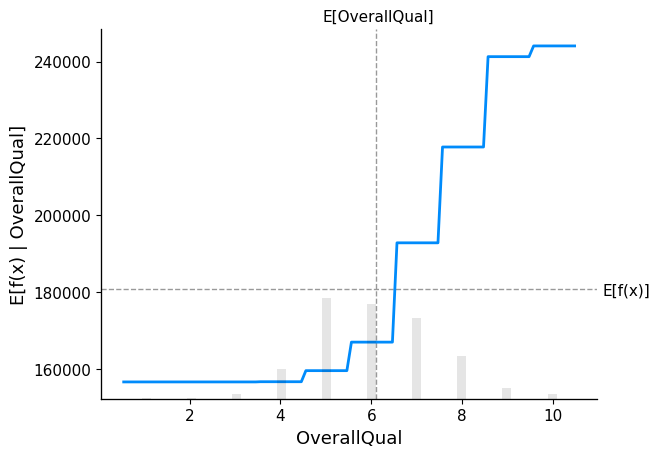

In [7]:
# SHAP partial dependence plot

shap.partial_dependence_plot(
    "OverallQual"
    , estimator.predict
    , X_train_imputed
    , ice=False
    , model_expected_value=True
    , feature_expected_value=True
)

In [8]:
# Visualizing SHAP values

X100 = shap.utils.sample(X_train_imputed, 100)
explainer = shap.Explainer(estimator.predict, X100)
shap_values = explainer(X100)

Permutation explainer: 101it [00:24,  3.08it/s]


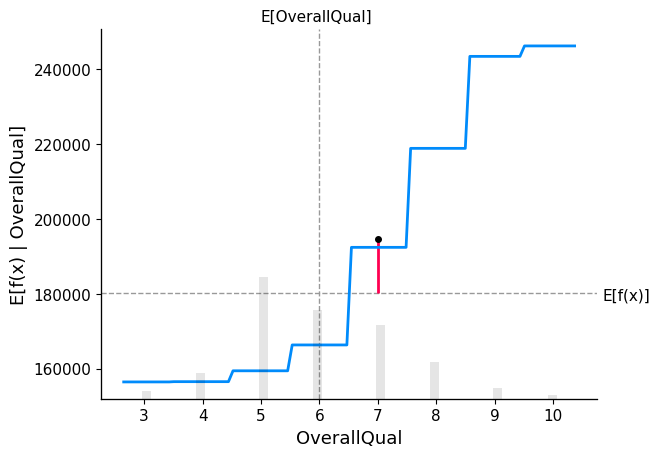

In [9]:
sample_index = 12
shap.partial_dependence_plot(
    "OverallQual"
    , estimator.predict
    , X100
    , ice=False
    , model_expected_value=True
    , feature_expected_value=True
    , shap_values=shap_values[sample_index:sample_index+1,:]
)

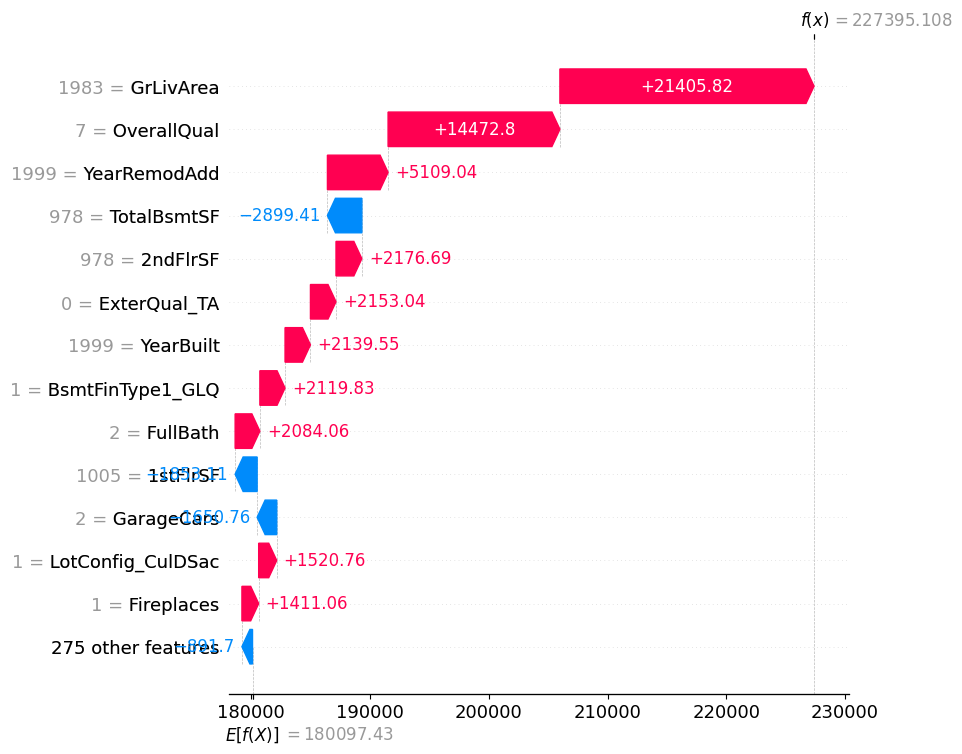

In [10]:
shap.plots.waterfall(shap_values[sample_index], max_display=14)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


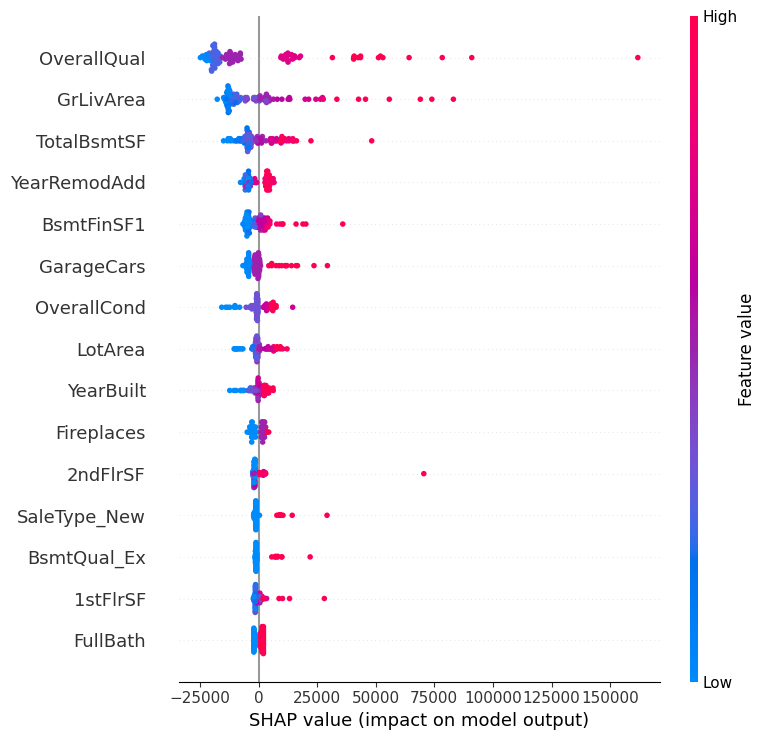

In [11]:
# Feature importance plots

shap.summary_plot(shap_values, max_display=15, show=False)

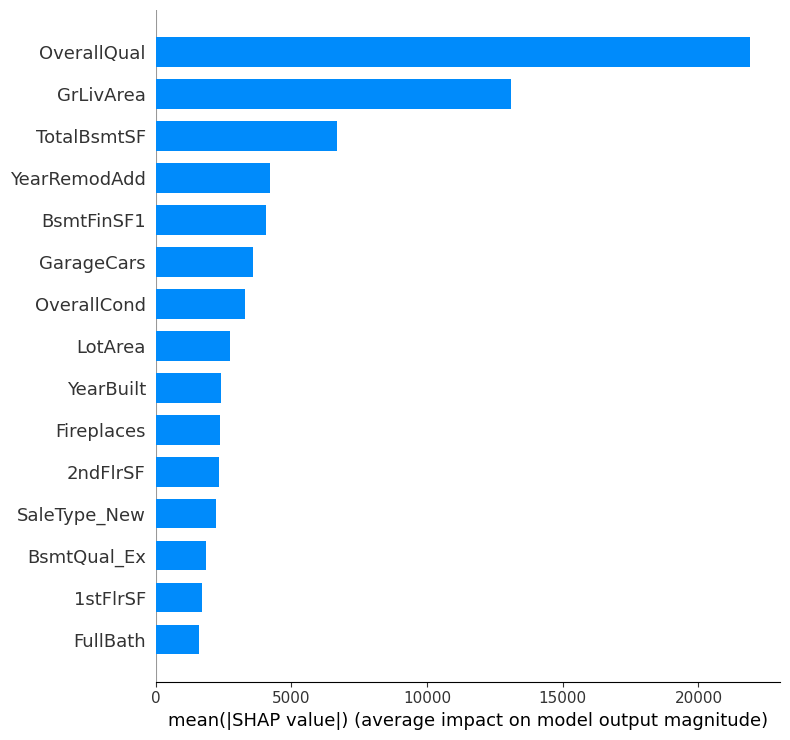

In [12]:
shap.summary_plot(shap_values, max_display=15, show=False, plot_type='bar')

In [13]:
feature_importance = pd.DataFrame({'name': X100.columns, 'importance': shap_values.abs.sum(0).values})
feature_importance= feature_importance.sort_values(by='importance', ascending=False).reset_index(drop=True)
feature_importance[feature_importance['importance']>0]

,name,importance
0,OverallQual,2.190766e+06
1,GrLivArea,1.310067e+06
2,TotalBsmtSF,6.681220e+05
3,YearRemodAdd,4.228247e+05
4,BsmtFinSF1,4.079906e+05
...,...,...
88,Neighborhood_Mitchel,3.345612e+02
89,HeatingQC_Gd,1.893305e+02
90,RoofStyle_Gable,9.093376e+01
91,PavedDrive_N,6.243017e+01


In [14]:
# Only keeping top features

X_train_final = X_train_imputed[feature_importance.head(25)["name"]]
final_estimator = GradientBoostingRegressor(random_state = 0)
final_estimator.fit(X_train_final, y_train)

GradientBoostingRegressor(random_state=0)

In [15]:
scores = cross_val_score(final_estimator, X_train_final, y_train, cv=5, scoring= 'r2')
print("Average CV score:", scores.mean())

Average CV score: 0.8902065949513261
